TD 4: Using a permutation test to select the relevant weights
=============================================================

Name: Pierre-Louis BARBARANT (Master MSV)

Question 1
----------

Run a full-brain SVM classification analysis on the Haxby dataset
(e.g. adapted from `plot_haxby_anova_svm.py`_, but without the anova step),
reduced to two classes: FACE versus BOTTLE. Plot the histogram of the
resulting weights.

`plot_haxby_anova_svm.py`: https://nilearn.github.io/auto_examples/02_decoding/plot_haxby_anova_svm.html


In [52]:
# Useful imports
from nilearn import datasets, image
from nilearn.decoding import Decoder
from nilearn.plotting import plot_stat_map, show
from sklearn.model_selection import LeaveOneGroupOut
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import warnings

# Ignore all warnings (for conciseness of the notebook)
warnings.filterwarnings("ignore")

In [53]:
# By default 2nd subject will be fetched
haxby_dataset = datasets.fetch_haxby()
func_img = haxby_dataset.func[0]
# print basic information on the dataset
print(f"Mask nifti image (3D) is located at: {haxby_dataset.mask}")
print(f"Functional nifti image (4D) is located at: {func_img}")

# Load target information as string and give a numerical identifier to each
behavioral = pd.read_csv(haxby_dataset.session_target[0], sep=" ")
conditions = behavioral["labels"]

# Restrict the analysis to faces and places
condition_mask = behavioral["labels"].isin(["face", "bottle"])
conditions = conditions[condition_mask]
func_img = image.index_img(func_img, condition_mask)

# Confirm that we now have 2 conditions
print(conditions.unique())

# The number of the run is stored in the CSV file giving the behavioral data.
# We have to apply our run mask, to select only faces and houses.
run_label = behavioral["chunks"][condition_mask]

Mask nifti image (3D) is located at: /home/mind/pbarbara/nilearn_data/haxby2001/mask.nii.gz
Functional nifti image (4D) is located at: /home/mind/pbarbara/nilearn_data/haxby2001/subj2/bold.nii.gz
['face' 'bottle']


In [54]:
cv = LeaveOneGroupOut()

mask_img = haxby_dataset.mask
decoder = Decoder(
    estimator="svc",
    mask=mask_img,
    standardize="zscore_sample",
    scoring="accuracy",
    cv=cv,
    n_jobs=20,
)
# Compute the prediction accuracy for the different folds (i.e. run)
decoder.fit(func_img, conditions, groups=run_label)

# Print the CV scores
print(decoder.cv_scores_["face"])

[0.6111111111111112, 0.9444444444444444, 0.9444444444444444, 0.8333333333333334, 0.8888888888888888, 0.5, 0.6111111111111112, 0.9444444444444444, 0.8888888888888888, 0.5, 1.0, 0.6111111111111112]


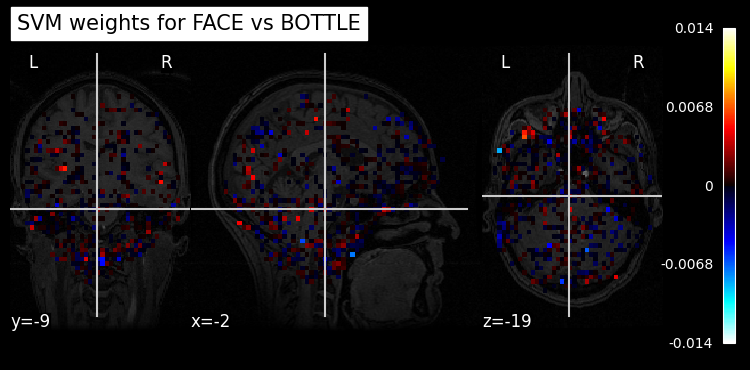

In [55]:
# Store the average accuracy
average_accuracy_original = np.mean(decoder.cv_scores_["face"])
weight_img_original = decoder.coef_img_["face"]

plot_stat_map(
    weight_img_original, 
    bg_img=haxby_dataset.anat[0], 
    title="SVM weights for FACE vs BOTTLE",
)

show()

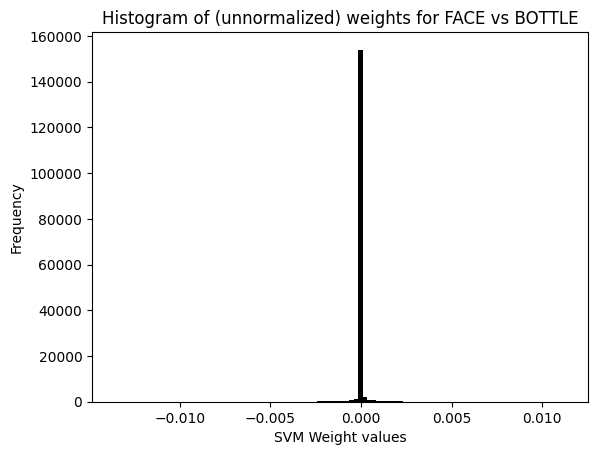

In [56]:
# Plot the histogram of the weights
weight_data_original = weight_img_original.get_fdata()

plt.hist(weight_data_original.ravel(), bins=100, color="black")
plt.xlabel("SVM Weight values")
plt.ylabel("Frequency")
plt.title("Histogram of (unnormalized) weights for FACE vs BOTTLE")
plt.show()

Question 2
----------

*In the next steps, the coefficient vector will be normalized to have unit l2 norm.*

Randomly shuffle the targets and repeat the estimation. Compare the
resulting weight histogram with the histogram in question 1.

In [57]:
def shuffle_conditions(conditions):
    conditions_shuffled = conditions.copy().values
    np.random.shuffle(conditions_shuffled)
    return conditions_shuffled


def normalize_weights(coefs):
    coefs_normalized = image.math_img(
        "img1 / np.sqrt((img1**2).sum())",
        img1=coefs,
    )
    return coefs_normalized


def compute_coefs(decoder, func_img, conditions, run_label):
    # Fit the decoder
    decoder.fit(func_img, conditions, groups=run_label)
    # Retrieve the coefficients
    coefs = decoder.coef_img_["face"]
    # Normalize the weights to have a unit L2 norm
    coefs_normalized = normalize_weights(coefs)
    return coefs_normalized


# Randomly shuffle the target variable and repeat the estimation
conditions_shuffled = shuffle_conditions(conditions)
coefs_normalized = compute_coefs(decoder, func_img, conditions_shuffled, run_label)

print(f"L2-norm of the weights: {np.linalg.norm(coefs_normalized.get_fdata())}")


L2-norm of the weights: 0.9999999999999999


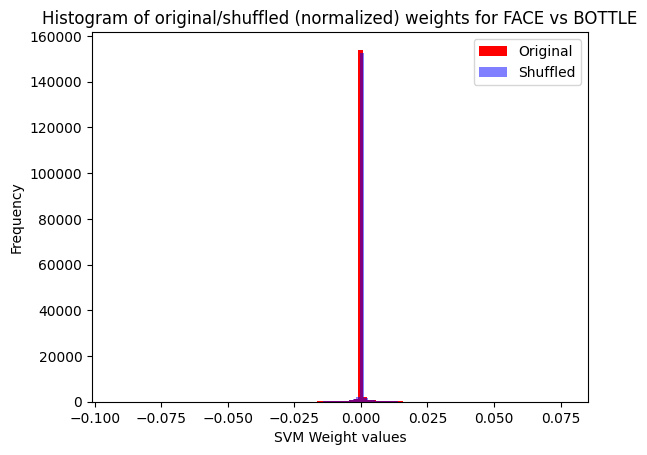

In [58]:
# Plot the histogram of the shuffled weights
weight_data_shuffled = coefs_normalized.get_fdata()

# Normalize the original weights for comparison
weight_data_original /= np.linalg.norm(weight_data_original)

plt.hist(weight_data_original.ravel(), bins=100, color="red", label="Original")
plt.hist(weight_data_shuffled.ravel(), bins=100, color="blue", alpha=0.5, label="Shuffled")
plt.xlabel("SVM Weight values")
plt.ylabel("Frequency")
plt.title("Histogram of original/shuffled (normalized) weights for FACE vs BOTTLE")
plt.legend()
plt.show()

Question 3
----------

Repeat the shufflings 100 times. Derive the distribution of the maximum
absolute value of the weight map across shufflings. Use this
distribution to find a threshold on the initial weight map in question. 1,
corresponding to à 5% *corrected* error control.  Display the
thresholded map and state how many voxels survive this thresholding
procedure.

In [59]:
N_permutations = 100

permuted_weights_list = []
for i in tqdm(range(N_permutations)):
    # Shuffle the target variable
    conditions_shuffled = shuffle_conditions(conditions)
    coefs_normalized = compute_coefs(decoder, func_img, conditions_shuffled, run_label)
    # Store the permuted weights
    weight_img_shuffled = coefs_normalized.get_fdata().ravel()
    permuted_weights_list.append(weight_img_shuffled)

permuted_weights_list = np.vstack(permuted_weights_list)

100%|██████████| 100/100 [15:33<00:00,  9.33s/it]


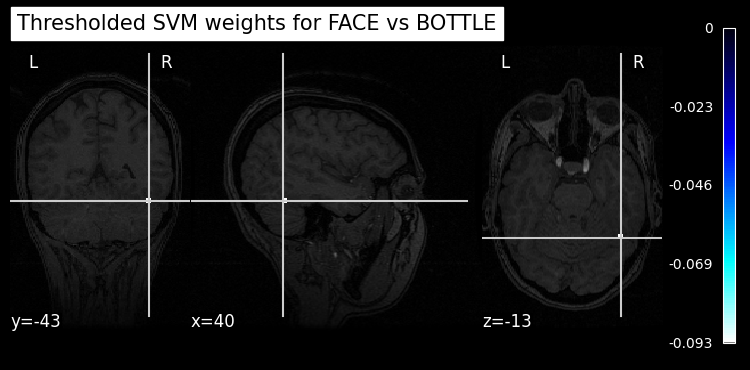

In [60]:
# Compute the distribution of the maximum absolute weight across the permutations
max_abs_weights = np.abs(permuted_weights_list).max(axis=1)

# Threshold the original weights at the 95th percentile of the null distribution
threshold = np.percentile(max_abs_weights, 95)

# Normalize the original weights
weight_img_original_normalized = normalize_weights(weight_img_original)

# Threshold the original weights
thresholded_img = image.math_img(f"img1 * (np.abs(img1) > {threshold})", img1=weight_img_original_normalized)

# Display the thresholded map
plot_stat_map(
    thresholded_img,
    bg_img=haxby_dataset.anat[0],
    title="Thresholded SVM weights for FACE vs BOTTLE",
)

In [61]:
# Print the number of non-zero voxels
n_voxels = np.sum(thresholded_img.get_fdata() != 0)
print(f"Number of voxels that survived the thresholding procedure: {n_voxels}")

Number of voxels that survived the thresholding procedure: 1


Question 4
----------

Based on 100 shufflings again, evaluate the distribution of the
prediction accuracy under the null hypothesis. What do you observe ?

In [62]:
N_permutations = 100

# Evaluate the distribution of the prediction accuracy under the null hypothesis
cv_scores_null = []
for i in tqdm(range(N_permutations)):
    # Shuffle the target variable
    conditions_shuffled = shuffle_conditions(conditions)
    # Fit the decoder
    decoder.fit(func_img, conditions_shuffled, groups=run_label)
    # Store the prediction accuracy
    cv_scores = decoder.cv_scores_["face"]
    # Append the average prediction accuracy
    cv_scores_null.append(np.mean(cv_scores))

100%|██████████| 100/100 [11:01<00:00,  6.62s/it]


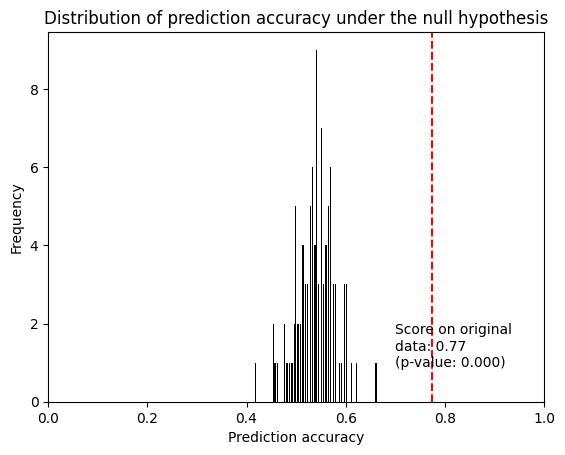

In [63]:
cv_scores_null = np.array(cv_scores_null)

# Compute the p-value
pvalue = np.mean(cv_scores_null > average_accuracy_original)

# Plot the distribution of the prediction accuracy under the null hypothesis
plt.hist(cv_scores_null, bins=100, color="black")
plt.axvline(average_accuracy_original, color="red", linestyle="--")
plt.text(0.7, .9, f"Score on original\ndata: {average_accuracy_original:.2f}\n(p-value: {pvalue:.3f})", color="black")
plt.xlabel("Prediction accuracy")
plt.ylabel("Frequency")
plt.xlim(0, 1)
plt.title("Distribution of prediction accuracy under the null hypothesis")
plt.show()